In [6]:
import torch
import copy
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import time
import os
from torch import nn, optim
from torch.optim import lr_scheduler
from PIL import Image
from torchvision import datasets, models, transforms
from IPython.display import display
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
os.environ["KMP_DUPLICATE_LIB_OK"] = "True"
#https://www.kaggle.com/datasets/sartajbhuvaji/brain-tumor-classification-mri

In [3]:
data_transforms = {
    'Training': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomRotation((-7,7)), 
        transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'Testing': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/kaggle/input/brain-tumor-classification-mri'

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['Training', 'Testing']}


dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                              shuffle=True, num_workers=4)
              for x in ['Training', 'Testing']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['Training', 'Testing']}

class_names = image_datasets['Training'].classes


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

for x in ["Training", "Testing"]:
    print("Loaded {} images under {}".format(dataset_sizes[x], x))
    
print("Classes: ", image_datasets["Training"].classes)

Loaded 2870 images under Training
Loaded 394 images under Testing
Classes:  ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']


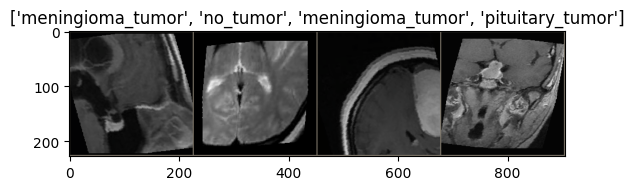

In [3]:
#Defining the Visualization function

def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Getting a batch of training data
inputs, classes = next(iter(dataloaders['Training']))

# Making a grid from batch
out = torchvision.utils.make_grid(inputs)

#Let's show them with their titles of class names
imshow(out, title=[class_names[x] for x in classes])

In [4]:
def train_model_with_cv(model, criterion, optimizer, scheduler, early_stopping=None, num_epochs=25, k_folds=5):
    since = time.time()
    best_acc = 0.0
    epochs_no_improve = 0
    best_epoch = 0
    best_model_params = None

    # Split the dataset into k folds
    fold_datasets = torch.utils.data.random_split(image_datasets['Training'], [len(image_datasets['Training']) // k_folds] * k_folds)

    for fold, fold_data in enumerate(fold_datasets):
        print(f'Fold {fold+1}/{k_folds}')
        print('-' * 10)

        # Initialize the model, optimizer, and scheduler for each fold
        model_ft = models.vgg16()
        model_ft.load_state_dict(torch.load("../input/download-pytorch-model/vgg16-397923af.pth"))
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs, len(class_names))
        model_ft = model_ft.to(device)

        optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
        exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

        fold_dataloader = torch.utils.data.DataLoader(fold_data, batch_size=4, shuffle=True, num_workers=4)

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            for phase in ['Training', 'Testing']:
                if phase == 'Training':
                    model_ft.train()
                else:
                    model_ft.eval()

                running_loss = 0.0
                running_corrects = 0

                for inputs, labels in fold_dataloader:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    optimizer_ft.zero_grad()

                    with torch.set_grad_enabled(phase == 'Training'):
                        outputs = model_ft(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        if phase == 'Training':
                            loss.backward()
                            optimizer_ft.step()

                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)

                if phase == 'Training':
                    scheduler.step()

                epoch_loss = running_loss / len(fold_data)
                epoch_acc = running_corrects.double() / len(fold_data)

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                if phase == 'Testing' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_epoch = epoch
                    best_model_params = copy.deepcopy(model_ft.state_dict())

                    if early_stopping is not None:
                        epochs_no_improve = 0
                elif phase == 'Testing':
                    if early_stopping is not None:
                        epochs_no_improve += 1
                        if epochs_no_improve >= early_stopping:
                            print("Early stopping!")
                            break  # Break out of inner loop to proceed to the next fold
            print()

        print(f'Fold {fold+1} best val Acc: {best_acc:4f} at epoch {best_epoch}')

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    return model_ft, best_model_params  # Return both the model and the best model parameters

In [ ]:
# Initialize the pretrained Vgg16 model
vgg16 = models.vgg16()
num_ftrs = vgg16.classifier[6].in_features
vgg16.load_state_dict(torch.load("../input/download-pytorch-model/vgg16-397923af.pth"))
features = list(vgg16.classifier.children())[:-1] # Remove last layer
features.extend([nn.Linear(num_ftrs, len(class_names))]) # Add our layer with 4 outputs
vgg16.classifier = nn.Sequential(*features) # Replace the model classifier

# Freeze training for all layers
for param in vgg16.features.parameters():
    param.require_grad = False

# Transfer the model to GPU if available
vgg16 = vgg16.to(device)

# Define loss function
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

# Train the model with cross validation
vgg16, best_model_params = train_model_with_cv(vgg16, criterion, optimizer_ft, exp_lr_scheduler, early_stopping=3, num_epochs=30, k_folds=1)

# Save the best model parameters
torch.save(best_model_params, 'best_model_params.pt')

Fold 1/1
----------
Epoch 0/29
----------
Training Loss: 1.1201 Acc: 0.5094
Testing Loss: 0.7273 Acc: 0.7206

Epoch 1/29
----------
Training Loss: 0.6988 Acc: 0.7303
Testing Loss: 0.7365 Acc: 0.7289

Epoch 2/29
----------
Training Loss: 0.5799 Acc: 0.7791
Testing Loss: 0.4284 Acc: 0.8328

Epoch 3/29
----------
Training Loss: 0.4978 Acc: 0.8091
Testing Loss: 0.3850 Acc: 0.8512

Epoch 4/29
----------
Training Loss: 0.4458 Acc: 0.8408
Testing Loss: 0.3115 Acc: 0.8808

Epoch 5/29
----------
Training Loss: 0.3966 Acc: 0.8547
Testing Loss: 0.3462 Acc: 0.8767

Epoch 6/29
----------
Training Loss: 0.3720 Acc: 0.8606
Testing Loss: 0.3022 Acc: 0.8875

Epoch 7/29
----------
Training Loss: 0.3269 Acc: 0.8753
Testing Loss: 0.3085 Acc: 0.8861

Epoch 8/29
----------
Training Loss: 0.3354 Acc: 0.8697
Testing Loss: 0.5637 Acc: 0.8000

Epoch 9/29
----------
Training Loss: 0.3250 Acc: 0.8798
Testing Loss: 0.2334 Acc: 0.9171

Epoch 10/29
----------
Training Loss: 0.2973 Acc: 0.8899
Testing Loss: 0.4154 Ac

In [33]:
def evaluate_on_testing_dataset(model, criterion, dataloader):
    """
    Evaluate the model on the testing dataset.

    Args:
        model: The trained model to be evaluated.
        criterion: The loss criterion used for evaluation.
        dataloader: The data loader for the testing dataset.

    Returns:
        epoch_acc: The accuracy of the model on the testing dataset.
        epoch_loss: The loss of the model on the testing dataset.
    """
    model.eval()  # Set the model to evaluation mode

    running_loss = 0.0
    running_corrects = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

    dataset_size = len(dataloader.dataset)
    epoch_loss = running_loss / dataset_size
    epoch_acc = running_corrects.double() / dataset_size

    return epoch_acc, epoch_loss

test_dataloader = torch.utils.data.DataLoader(image_datasets['Testing'], batch_size=4, shuffle=False, num_workers=4)

y_true, y_pred = evaluate_model(vgg16, test_dataloader)

accuracy = accuracy_score(y_true, y_pred)

f1 = f1_score(y_true, y_pred, average='weighted')

precision = precision_score(y_true, y_pred, average='weighted')

recall = recall_score(y_true, y_pred, average='weighted')

print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)


Accuracy: 0.7969543147208121
F1 Score: 0.7805307427728154
Precision: 0.8389418032995541
Recall: 0.7969543147208121
